In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
base = 50
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.80 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=16, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=16, shuffle=False)

# Show specific samples:
# show_iris_samples(X_iris_shuffled, y_iris_shuffled, indices=[0, 50, 100])


# Example usage (deterministic training):
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.01)
iris_losses, trained_iris = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=base, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/50], Loss: 0.145567
Epoch [40/50], Loss: 0.107952


In [5]:
X_iris_test.shape

torch.Size([30, 4])

In [6]:
# Show Example of dataset
show_iris_samples(X_iris_shuffled, y_iris_shuffled, indices=75)  # Single index

# Make prediction
print()
predictions_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=5)  # Single index

Iris Dataset Samples:
--------------------------------------------------------------------------------
Index  Class        Sepal_L  Sepal_W  Petal_L  Petal_W 
--------------------------------------------------------------------------------
75     versicolor   5.40     3.00     4.50     1.50    

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      versicolor   versicolor   0.9979      


In [7]:
iris_inputs, iris_activations, iris_outputs = get_activations(trained_iris, iris_train_loader, dataset_type='iris')
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris, iris_test_loader, dataset_type='iris', indices=5)

In [8]:
single_iris_activations.shape

torch.Size([1, 384])

In [9]:
indices_iris, distances_iris = find_knn(iris_activations, single_iris_activations, k=5, metric='l2')
filtered_iris_loader, filtered_size = create_filtered_dataloader(iris_train_loader, exclude_indices=indices_iris, batch_size=16, shuffle=False)

In [10]:
distances_iris

tensor([0.8163, 0.9100, 1.2413, 1.5152, 1.7298])

In [11]:
filter_iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(filter_iris_model.parameters(), lr=0.01)
iris_losses, filter_trained_iris = train_model(filter_iris_model, filtered_iris_loader, iris_criterion, iris_optimizer, num_epochs=base, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/50], Loss: 0.163144
Epoch [40/50], Loss: 0.106242


In [12]:
# Base Model prediction
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=5)

# Filtered Model prediction
predictions_filter_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(filter_trained_iris, iris_test_loader, dataset_type='iris', indices=5)

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      versicolor   versicolor   0.9979      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      versicolor   versicolor   0.9981      


In [13]:
print(nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris))
print(nn.CrossEntropyLoss()(predictions_filter_iris, sample_targets_iris))

tensor(0.0021)
tensor(0.0019)


In [14]:
def retrain_entropy_for_k_and_indices(model, train_loader, test_loader, list_of_k, list_of_indices, metric ='cosine'):
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    # New: store k-NN distances per subset / k / sample
    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='iris', indices=index)

            # Find k-nearest neighbors for the entire dataset (get full ordering + distances)
            indices_knn, distances = find_knn(iris_activations, single_activations, k=len(iris_activations), metric=metric)

            # Closest k neighbors and their distances
            closest_indices = indices_knn[:k]
            closest_dists = [float(d) for d in distances[:k]]

            # Last k neighbors and their distances
            last_indices = indices_knn[-k:]
            last_dists = [float(d) for d in distances[-k:]]

            # Random k neighbors (sampled from the ordering) and their distances
            random_indices = np.random.choice(indices_knn, k, replace=False)
            # build map for lookup
            dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}
            random_dists = [dist_map[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists in zip(
                    ['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists, last_dists, random_dists]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=16, shuffle=False)

                # Train a new model completely with the filtered dataset
                filtered_model = IrisNet()
                optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.01)
                criterion = nn.CrossEntropyLoss()
                train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=base, seed=42, verbose=False, continue_training=False)

                # Predict and calculate CrossEntropy loss
                predictions, _, _, targets = predict_and_show(filtered_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name][k].append(cross_loss)

                # store the corresponding k distances
                dist_key = subset_name.replace('_cross_entropy', '_distances')
                knn_distances[dist_key][k].append(list(map(float, subset_dists)))

    return cross_results, knn_distances

In [15]:
# Version 2: recompute activations on the filtered training set before k-NN so distances reflect the filtered dataset
# This is a copy of retrain_entropy_for_k_and_indices with the necessary changes; it returns the same (cross_results, knn_distances)

def retrain_entropy_for_k_and_indices_v2(model, train_loader, test_loader, list_of_k, list_of_indices, metric='cosine'):
    """Like retrain_entropy_for_k_and_indices but recalculates activations for the filtered
    training set before computing k-NN. This ensures stored k-NN distances are computed
    relative to the filtered dataset (i.e. after removing the excluded indices).

    Returns: cross_results, knn_distances (same structure as original)
    """
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    # Store k-NN distances per subset / k / sample — distances here correspond to the filtered train set
    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample (from the provided model)
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='iris', indices=index)

            # For each subset we will create the filtered dataloader first, then compute activations
            # for that filtered training set (using the same model) and then run k-NN between
            # the filtered training activations and the single sample's activations. This ensures
            # we measure distances relative to the filtered dataset.

            # Prepare neighbor candidates for the full filtered dataset.
            # We'll still exclude subset_indices from the original train set and compute activations on the remaining samples.
            for subset_name_template, subset_selector in [
                ('closest_cross_entropy', 'closest'),
                ('last_cross_entropy', 'last'),
                ('random_cross_entropy', 'random')
            ]:
                # To determine subset_indices we need the ordering of neighbors in the original (unfiltered) train set
                # Use iris_activations (assumed available in the notebook) to get the full ordering; fall back to computing it
                try:
                    base_indices_knn, base_distances = find_knn(iris_activations, single_activations, k=len(iris_activations), metric=metric)
                except Exception:
                    # if iris_activations not available, compute activations for full train_loader
                    _, full_train_activations, _ = get_activations(model, train_loader, dataset_type='iris')
                    base_indices_knn, base_distances = find_knn(full_train_activations, single_activations, k=len(full_train_activations), metric=metric)

                if subset_selector == 'closest':
                    subset_indices = base_indices_knn[:k]
                    subset_dists_initial = [float(d) for d in base_distances[:k]]
                elif subset_selector == 'last':
                    subset_indices = base_indices_knn[-k:]
                    subset_dists_initial = [float(d) for d in base_distances[-k:]]
                else:  # random
                    # random selection from the base ordering (still referencing full train ordering)
                    subset_indices = np.random.choice(base_indices_knn, k, replace=False)
                    # build map for lookup
                    dist_map = {int(idx): float(d) for idx, d in zip(base_indices_knn, base_distances)}
                    subset_dists_initial = [dist_map[int(i)] for i in subset_indices]

                # Create filtered dataloader removing subset_indices
                filtered_loader, filtered_size = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=16, shuffle=False)

                # Compute activations for the filtered training set using the same (base) model
                # This is the key change vs original: compute activations AFTER filtering
                if filtered_size == 0:
                    # nothing left in filtered set; record NaNs and continue
                    print(f"Filtered training set empty after excluding subset for index={index}, k={k}, subset={subset_name_template}")
                    cross_results[subset_name_template][k].append(float('nan'))
                    # store empty distance list
                    knn_distances[subset_name_template.replace('_cross_entropy', '_distances')][k].append([])
                    continue

                _, filtered_activations, _ = get_activations(model, filtered_loader, dataset_type='iris')

                # If filtered_activations has fewer than k samples, adjust effective k
                eff_k = min(k, len(filtered_activations))

                # Run k-NN on the filtered activations against the single activation
                indices_knn_filtered, distances_filtered = find_knn(filtered_activations, single_activations, k=len(filtered_activations), metric=metric)

                # Derive the subset indices/dists relative to the filtered set ordering
                if subset_selector == 'closest':
                    sel_indices = indices_knn_filtered[:eff_k]
                    sel_dists = [float(d) for d in distances_filtered[:eff_k]]
                elif subset_selector == 'last':
                    sel_indices = indices_knn_filtered[-eff_k:]
                    sel_dists = [float(d) for d in distances_filtered[-eff_k:]]
                else:
                    # For random, sample from the filtered ordering (safe even if eff_k < k)
                    sel_indices = np.random.choice(indices_knn_filtered, eff_k, replace=False)
                    dist_map_filtered = {int(idx): float(d) for idx, d in zip(indices_knn_filtered, distances_filtered)}
                    sel_dists = [dist_map_filtered[int(i)] for i in sel_indices]

                # Now train on the filtered dataset (same as before)
                filtered_model = IrisNet()
                optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.01)
                criterion = nn.CrossEntropyLoss()
                train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=base, seed=42, verbose=False, continue_training=False)

                # Predict and calculate CrossEntropy loss on the test sample
                predictions, _, _, targets = predict_and_show(filtered_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name_template][k].append(cross_loss)

                # Store the distances we computed on the filtered dataset
                dist_key = subset_name_template.replace('_cross_entropy', '_distances')
                knn_distances[dist_key][k].append(list(map(float, sel_dists)))

    return cross_results, knn_distances


In [16]:
list_of_k = list(range(0, 101, 10))
list_of_k[0] = 1
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = list(range(0, 30, 1))
random_indices = random.sample(list_of_indices, k=15)

print(list_of_k)

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [17]:
# cross_results, knn_distances = retrain_entropy_for_k_and_indices(trained_iris, iris_train_loader, iris_test_loader, list_of_k, random_indices)

# # Save random_indices to a file
# with open('retrain_data/cosine/random_indices_50.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save cross_results to a file
# with open('retrain_data/cosine/cross_results_50.pkl', 'wb') as f:
#     pickle.dump(cross_results, f)

# # Save knn_distances to a file
# with open('retrain_data/cosine/knn_distances_50.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)   

In [18]:
cross_results, knn_distances = retrain_entropy_for_k_and_indices_v2(trained_iris, iris_train_loader, iris_test_loader, list_of_k, random_indices, metric='l1')

# Save knn_distances to a file
with open('retrain_data/l1/knn_distances_50.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)   



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
20     versicolor   versicolor   0.9798      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
20     versicolor   versicolor   0.9828      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
20     versicolor   versicolor   0.9826      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
-----------

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
20     versicolor   versicolor   0.9776      


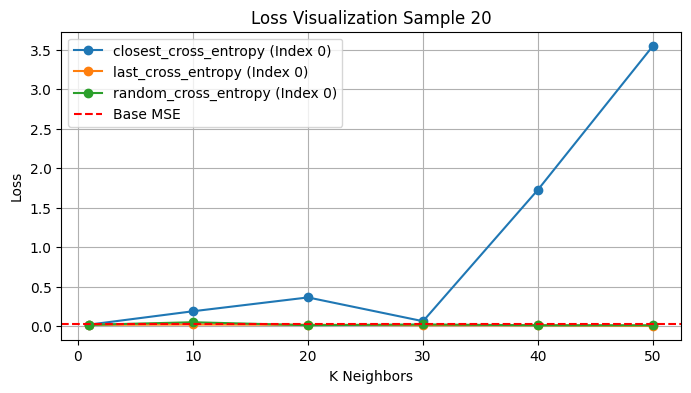

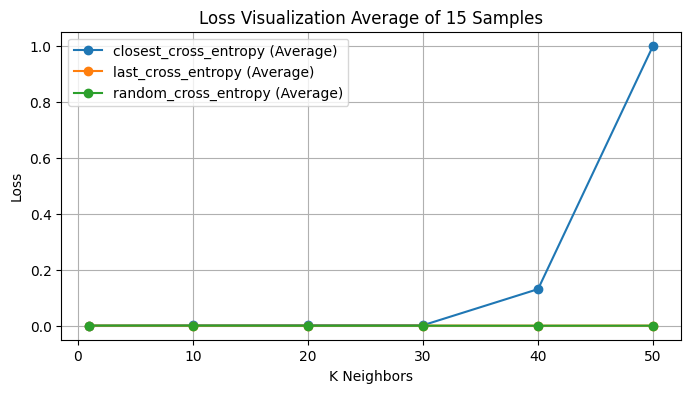

In [20]:
index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris)

max_knn = 50  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"Loss Visualization Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(cross_results, list_of_indices, average=True, normalize=True, title=f"Loss Visualization Average of {len(random_indices)} Samples", max_knn=max_knn)

In [22]:
knn_distances['closest_distances'].items()

dict_items([(1, [[25.937461853027344], [13.715746879577637], [12.386980056762695], [18.65592384338379], [8.759889602661133], [18.132274627685547], [11.874086380004883], [8.80372428894043], [10.132013320922852], [20.31878089904785], [13.616410255432129], [13.748089790344238], [12.676288604736328], [41.26164627075195], [17.768226623535156]]), (10, [[38.420875549316406, 40.69392776489258, 41.7420768737793, 41.974552154541016, 41.98583221435547, 42.68434524536133, 42.91312026977539, 44.6135139465332, 44.74311828613281, 47.1319465637207], [27.668201446533203, 28.51112937927246, 34.01905822753906, 34.06071090698242, 37.111515045166016, 37.6524772644043, 38.96900177001953, 39.077857971191406, 39.20684814453125, 39.55266571044922], [23.646150588989258, 24.583255767822266, 25.71265983581543, 28.83489227294922, 30.034391403198242, 32.2081298828125, 32.788570404052734, 34.068607330322266, 35.72340774536133, 37.17321014404297], [31.100923538208008, 33.00439453125, 33.98381423950195, 35.50596237182

1: min=8.75989  max=41.2616  avg=16.5192
10: min=14.9304  max=65.8292  avg=35.9999
20: min=25.4966  max=105.239  avg=56.586
30: min=30.6456  max=266.463  avg=109.043
40: min=49.7612  max=339.495  avg=160.979
50: min=86.5234  max=372.069  avg=215.332
60: min=100.898  max=465.05  avg=257.278
70: min=117.27  max=465.05  avg=274.915
80: min=189.243  max=465.05  avg=290.635
90: min=200.239  max=465.05  avg=299.181
100: min=209.164  max=465.05  avg=307.95


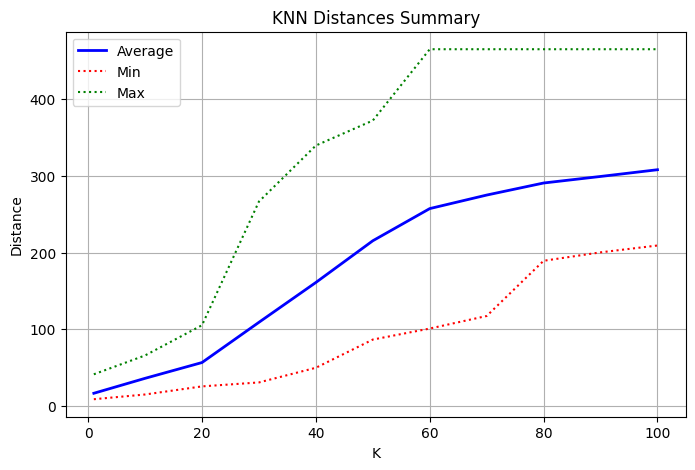

In [23]:
import statistics as stats

closest = knn_distances['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x = sorted(summary.keys())
y_min = [summary[k]["min"] for k in x]
y_max = [summary[k]["max"] for k in x]
y_avg = [summary[k]["avg"] for k in x]

plt.figure(figsize=(8,5))

# Plot avg as solid line
plt.plot(x, y_avg, label="Average", color="blue", linewidth=2)

# Plot min and max as dotted lines
plt.plot(x, y_min, label="Min", color="red", linestyle="dotted")
plt.plot(x, y_max, label="Max", color="green", linestyle="dotted")

plt.title("KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()    

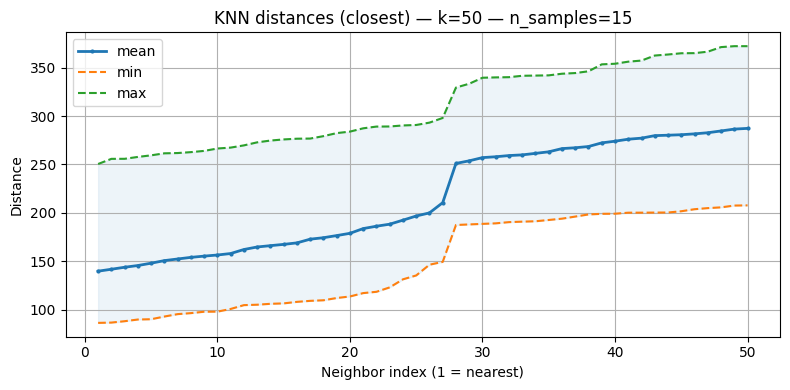

NameError: name 'inspect_knn_distances' is not defined

In [24]:
plot_knn_distance_stats(knn_distances, subset='closest',k=50)
inspect_knn_distances(knn_distances, subset='closest')